In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/fabric-defect-dataset/FYP/Fabric Defects Dataset/Fabric Defect Dataset/Vertical/20.jpg
/kaggle/input/fabric-defect-dataset/FYP/Fabric Defects Dataset/Fabric Defect Dataset/Vertical/6.jpg
/kaggle/input/fabric-defect-dataset/FYP/Fabric Defects Dataset/Fabric Defect Dataset/Vertical/5_processed (3).jpg
/kaggle/input/fabric-defect-dataset/FYP/Fabric Defects Dataset/Fabric Defect Dataset/Vertical/7_processed (1).jpg
/kaggle/input/fabric-defect-dataset/FYP/Fabric Defects Dataset/Fabric Defect Dataset/Vertical/7_processed (2).jpg
/kaggle/input/fabric-defect-dataset/FYP/Fabric Defects Dataset/Fabric Defect Dataset/Vertical/4_processed(3).jpg
/kaggle/input/fabric-defect-dataset/FYP/Fabric Defects Dataset/Fabric Defect Dataset/Vertical/5.jpg
/kaggle/input/fabric-defect-dataset/FYP/Fabric Defects Dataset/Fabric Defect Dataset/Vertical/8.jpg
/kaggle/input/fabric-defect-dataset/FYP/Fabric Defects Dataset/Fabric Defect Dataset/Vertical/9_processed (2).jpg
/kaggle/input/fabric-defect-da

In [2]:
# Install required library
!pip install transformers

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset, Dataset, random_split
from torchvision import transforms
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.preprocessing import label_binarize
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import os
from torch.optim.lr_scheduler import CosineAnnealingLR
from collections import Counter
from transformers import ViTModel  # Vision Transformer import
import random 


In [3]:
# Dataset Class (Remains Same)
class FabricDefectDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = os.listdir(root_dir)
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}
        self.images = self._load_images()

    def _load_images(self):
        images = []
        for cls in self.classes:
            cls_dir = os.path.join(self.root_dir, cls)
            for img_name in os.listdir(cls_dir):
                img_path = os.path.join(cls_dir, img_name)
                images.append((img_path, self.class_to_idx[cls]))
        return images

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path, label = self.images[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label

In [4]:
# Transformations (Same as Before)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [5]:
# Load Dataset
dataset = FabricDefectDataset(root_dir='/kaggle/input/fabric-defect-dataset/FYP/Fabric Defects Dataset/Fabric Defect Dataset', transform=transform)

In [6]:
# Train-Test Split
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

In [7]:
# Oversampling Function (Same)
def oversample_dataset(dataset):
    labels = [label for _, label in dataset]
    class_counts = Counter(labels)
    max_count = max(class_counts.values())
    oversampled_data = []
    for class_idx, count in class_counts.items():
        class_samples = [data for data in dataset if data[1] == class_idx]
        oversampled_data.extend(class_samples)
        if count < max_count:
            oversampled_data.extend(random.choices(class_samples, k=max_count - count))
    return oversampled_data

train_dataset = oversample_dataset(train_dataset)

In [8]:
# Data Loaders (Same)
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [9]:
# Vision Transformer Model
class ViTForFabricDefect(nn.Module):
    def __init__(self, num_classes):
        super(ViTForFabricDefect, self).__init__()
        self.vit = ViTModel.from_pretrained('google/vit-base-patch16-224-in21k')
        self.classifier = nn.Linear(self.vit.config.hidden_size, num_classes)
        
    def forward(self, x):
        outputs = self.vit(pixel_values=x)
        logits = self.classifier(outputs.last_hidden_state[:, 0, :])  # Use CLS token
        return logits

# Initialize Model
model = ViTForFabricDefect(num_classes=len(dataset.classes))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Unfreeze all parameters
for param in model.parameters():
    param.requires_grad = True

# Loss and Optimizer (Same)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0001)
scheduler = CosineAnnealingLR(optimizer, T_max=15, eta_min=0.00001)


config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Epoch [1/15]
Train Loss: 0.4521, Acc: 86.18%
Test Loss: 0.1641, Acc: 95.40%

Epoch [2/15]
Train Loss: 0.0994, Acc: 97.84%
Test Loss: 0.1432, Acc: 95.91%

Epoch [3/15]
Train Loss: 0.0594, Acc: 98.66%
Test Loss: 0.1744, Acc: 95.40%

Epoch [4/15]
Train Loss: 0.0228, Acc: 99.60%
Test Loss: 0.1298, Acc: 95.91%

Epoch [5/15]
Train Loss: 0.0111, Acc: 99.86%
Test Loss: 0.1573, Acc: 96.68%

Epoch [6/15]
Train Loss: 0.0308, Acc: 99.32%
Test Loss: 0.2405, Acc: 92.58%

Epoch [7/15]
Train Loss: 0.1048, Acc: 96.58%
Test Loss: 0.1529, Acc: 94.63%

Epoch [8/15]
Train Loss: 0.0077, Acc: 99.93%
Test Loss: 0.1664, Acc: 95.40%

Epoch [9/15]
Train Loss: 0.0033, Acc: 100.00%
Test Loss: 0.1709, Acc: 95.91%

Epoch [10/15]
Train Loss: 0.0028, Acc: 100.00%
Test Loss: 0.1737, Acc: 95.91%

Epoch [11/15]
Train Loss: 0.0025, Acc: 100.00%
Test Loss: 0.1760, Acc: 96.16%

Epoch [12/15]
Train Loss: 0.0023, Acc: 100.00%
Test Loss: 0.1777, Acc: 96.16%

Epoch [13/15]
Train Loss: 0.0022, Acc: 100.00%
Test Loss: 0.1791, Acc

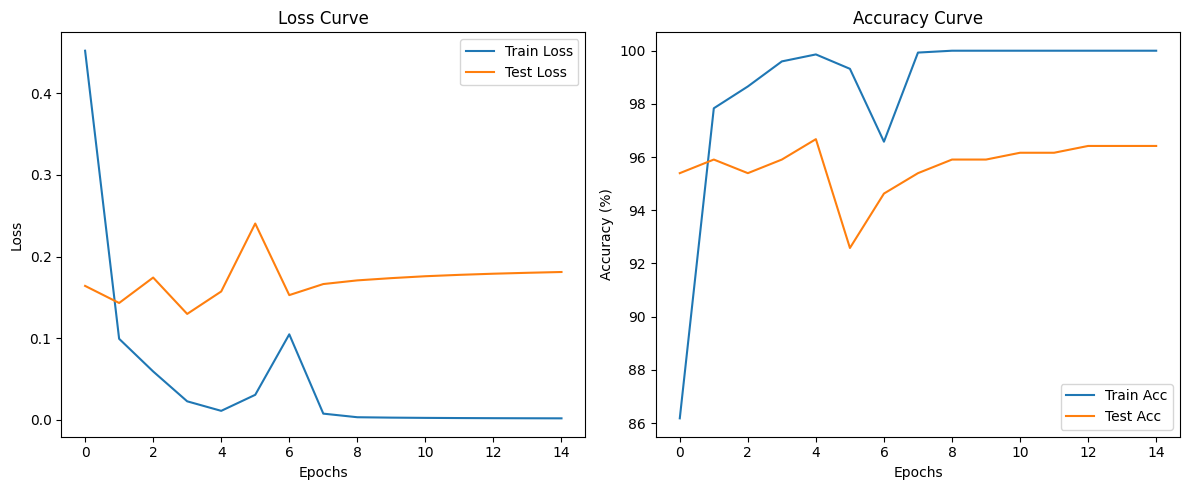

Model saved as 'mixeddataset_vit_oversampling.pth'

Classification Report:
              precision    recall  f1-score   support

    Vertical       1.00      0.92      0.96        12
 defect free       0.99      0.98      0.98       222
  horizontal       0.75      0.75      0.75         4
        hole       0.87      0.93      0.90        29
       lines       0.92      0.88      0.90        26
       stain       0.95      0.98      0.96        98

    accuracy                           0.96       391
   macro avg       0.91      0.91      0.91       391
weighted avg       0.96      0.96      0.96       391



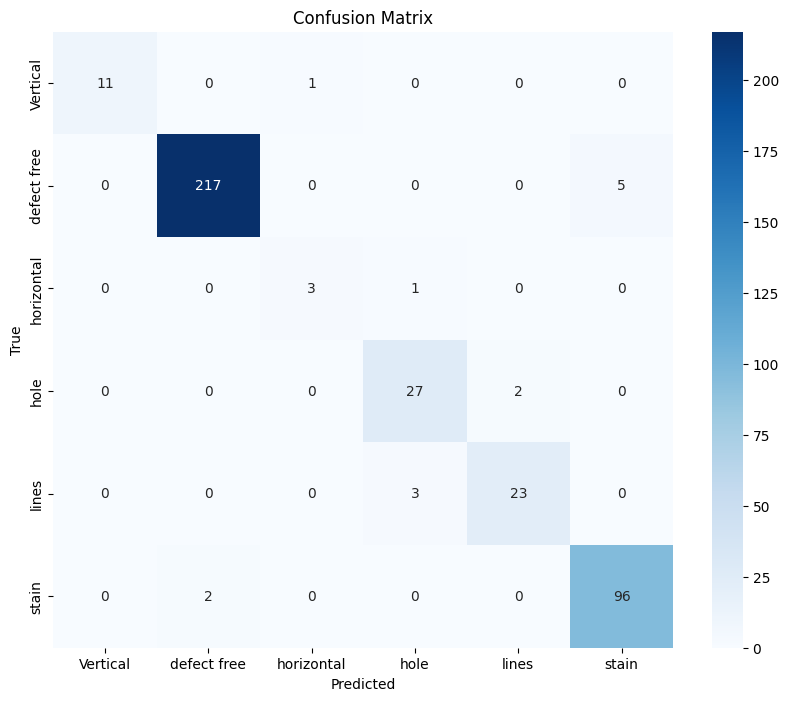

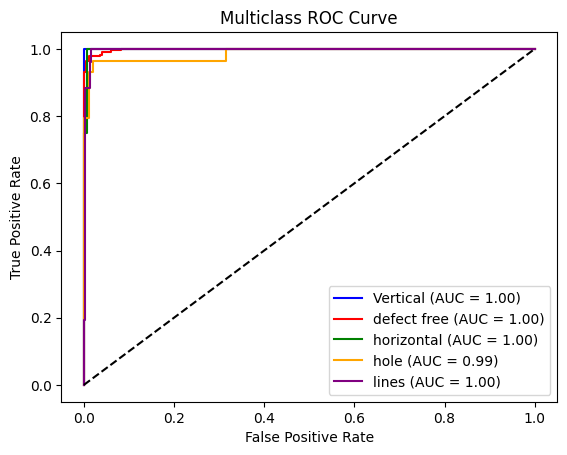

In [10]:
# Training Loop (Same)
num_epochs = 15
train_losses, val_losses, train_accs, val_accs = [], [], [], []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    
    train_loss = running_loss / len(train_loader)
    train_acc = 100. * correct / total
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    
    # Validation
    model.eval()
    test_running_loss = 0.0
    test_correct = 0
    test_total = 0
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            test_running_loss += loss.item()
            _, predicted = outputs.max(1)
            test_total += labels.size(0)
            test_correct += predicted.eq(labels).sum().item()
    
    test_loss = test_running_loss / len(test_loader)
    test_acc = 100. * test_correct / test_total
    val_losses.append(test_loss)
    val_accs.append(test_acc)
    
    print(f'Epoch [{epoch + 1}/{num_epochs}]')
    print(f'Train Loss: {train_loss:.4f}, Acc: {train_acc:.2f}%')
    print(f'Test Loss: {test_loss:.4f}, Acc: {test_acc:.2f}%\n')
    scheduler.step()

# Plotting (Same)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Test Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Acc')
plt.plot(val_accs, label='Test Acc')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.tight_layout()
plt.show()

# Save Model
torch.save(model.state_dict(), 'mixeddataset_vit_oversampling.pth')
print("Model saved as 'mixeddataset_vit_oversampling.pth'")

# Evaluation (Same)
model.eval()
true_labels, predicted_labels, predictions = [], [], []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = outputs.max(1)
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())
        predictions.extend(torch.softmax(outputs, dim=1).cpu().numpy())

print("\nClassification Report:")
print(classification_report(true_labels, predicted_labels, target_names=dataset.classes))

# Confusion Matrix
cm = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=dataset.classes, yticklabels=dataset.classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# ROC Curve
true_labels_bin = label_binarize(true_labels, classes=np.arange(len(dataset.classes)))
fpr, tpr, roc_auc = {}, {}, {}
for i in range(len(dataset.classes)):
    fpr[i], tpr[i], _ = roc_curve(true_labels_bin[:, i], np.array(predictions)[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure()
colors = ['blue', 'red', 'green', 'orange', 'purple']
for i, color in zip(range(len(dataset.classes)), colors):
    plt.plot(fpr[i], tpr[i], color=color, label=f'{dataset.classes[i]} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC Curve')
plt.legend(loc="lower right")
plt.show()